In [1]:
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, LineString, mapping
from shapely.ops import unary_union, polygonize
import glob
import pandas as pd
import csv
from datetime import datetime
import time


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_48148\3616590515.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https:

In [2]:
# Define engines
engines = {
    'fiona': {'engine': 'fiona'},
    'pyogrio': {'engine': 'pyogrio'},
    'pyogrio+arrow': {'engine': 'pyogrio', 'use_arrow': True}
          
}

def write_log(log_path, log_entry):
    # Check if the file exists to determine if headers need to be written
    file_exists = os.path.isfile(log_path)

    # Open the log file in append mode
    with open(log_path, 'a', newline='') as csvfile:
        log_writer = csv.writer(csvfile)

        # Write the header if the file is new
        if not file_exists:
            log_writer.writerow(["uc_code","uc_name","ctry_code","TotalUCAreaHa",
                                 "UC_UA_AreaHa","UC_UA_Pop","UC_UA_NCM_AreaHa","UC_UA_NCM_Pop",
                                 "Perc_coverage_Area","Perc_coverage_Pop","TotalGreen_urbc_ncm_Ha",
                                 "TotalGreenQuietAreaHa","TotalGQAPop","TotalGQAPop_p","PercGreenQuietArea",
                                 "PercGreenQuietPop","PercGreenQuietPop_p","weighted_median_Ha","TotalGreenAreaHa",
                                 "green_excludedHa"])

        # Write the log entry
        log_writer.writerow(log_entry)

def create_log_entry(val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12, val13, val14, val15, val16, val17, val18):
    return [val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12, val13, val14, val15, val16, val17, val18]



In [3]:
# Path to data folders
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
step3_f = os.path.join(indata_f, 'OutputData', 'step3_SA', 'Dissolved')
outdata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData'
ua_data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
# Load urban center delineation
path = os.path.join(indata_f, 'UrbanCentres', 'HDC2021_RG_InputUpdateB2B3B4Copy.shp') 
urban_centers = gpd.read_file(path)

# NOISE DATA
# Load agglomerations delineations
agls_file_path = os.path.join(indata_f, 'NoiseData', 'DF1_5_Agglomerations_20240429.gpkg')
# Read the GeoPackage file
agls = gpd.read_file(agls_file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery', 
                     **engines['pyogrio+arrow'],columns=['agglomerationId_identifier', 'agglomerationName_nameEng', 'geometry'])

# TRANSLATOR TABLE
# Crosswalk table containing the different codes from input sources
codes_path = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\Codes.csv'
codes = pd.read_csv(codes_path)

# GQA
path2FinalGQA = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step2_GQA_Final'

# FINAL OUTPUT TABLE
csv_name = 'GQATotals_DGREGIO_v01.csv'
csv_path = os.path.join(outdata_f, 'OutTables', csv_name)

In [4]:
csv_name = 'GQATotals_DGREGIO_v02.csv'
csv_path = os.path.join(outdata_f, 'OutTables', csv_name)
SA_ls = ['GEOSTAT21_222',
 'GEOSTAT21_297',
 'GEOSTAT21_334',
 'GEOSTAT21_363',
 'GEOSTAT21_405',
 'GEOSTAT21_408',
 'GEOSTAT21_511',
 'GEOSTAT21_650', 
 'GEOSTAT21_901',
 'GEOSTAT21_925']

In [13]:
uc_code = 'GEOSTAT21_222'

In [15]:
codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.tolist()

['NL001L3_S_GRAVENHAGE_UA2018_v013', 'NL003L3_ROTTERDAM_UA2018_v013']

In [ ]:
ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()

In [16]:
SA_ls

['GEOSTAT21_222',
 'GEOSTAT21_297',
 'GEOSTAT21_334',
 'GEOSTAT21_363',
 'GEOSTAT21_405',
 'GEOSTAT21_408',
 'GEOSTAT21_511',
 'GEOSTAT21_650',
 'GEOSTAT21_901',
 'GEOSTAT21_925']

In [6]:
uc_code= 'GEOSTAT21_511'
GQA_path = os.path.join(path2FinalGQA, f'{uc_code}_finalGQA.shp')
GQA = gpd.read_file(GQA_path)
GQA = GQA.reset_index().rename(columns={'index': 'GQA_FID'})


In [7]:
GQA

,GQA_FID,country,fua_name,fua_code,HDENS_2011,code_2018,class_2018,noisy,area_m2,area_ha,area_km2,geometry
0,0,CH,Winterthur,CH006L1,GEOSTAT11_511,14100,Green urban areas,0.0,2.834500e+03,0.28,0.00,"POLYGON ((4224168.882 2709067.514, 4224134.384..."
1,1,CH,Winterthur,CH006L1,GEOSTAT11_511,14100,Green urban areas,0.0,1.315997e+04,1.32,0.01,"POLYGON ((4224446.691 2709329.687, 4224446.922..."
2,2,CH,Winterthur,CH006L1,GEOSTAT11_511,14100,Green urban areas,0.0,4.091220e+03,0.41,0.00,"POLYGON ((4223765.021 2709154.538, 4223810.556..."
3,3,CH,Winterthur,CH006L1,GEOSTAT11_511,14100,Green urban areas,0.0,6.448563e+03,0.64,0.01,"POLYGON ((4224714.983 2709507.782, 4224700.094..."
4,4,CH,Winterthur,CH006L1,GEOSTAT11_511,14100,Green urban areas,0.0,2.418179e+03,0.24,0.00,"POLYGON ((4222886.462 2708365.955, 4222873.837..."
...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,CH,Winterthur,CH006L1,GEOSTAT11_511,31000,Forests,0.0,1.021349e+06,102.13,1.02,"POLYGON ((4224802.298 2712672.525, 4224803.960..."
75,75,CH,Winterthur,CH006L1,GEOSTAT11_511,14100,Green urban areas,0.0,3.481498e+04,3.48,0.03,"POLYGON ((4227267.934 2712826.448, 4227275.274..."
76,76,CH,Winterthur,CH006L1,GEOSTAT11_511,31000,Forests,0.0,1.214946e+03,0.12,0.00,"POLYGON ((4227808.393 2712881.626, 4227807.835..."
77,77,CH,Winterthur,CH006L1,GEOSTAT11_511,31000,Forests,0.0,2.143437e+02,0.02,0.00,"POLYGON ((4222000.000 2708265.844, 4222253.582..."


In [6]:
if os.path.exists(csv_path): 
    outtbl = pd.read_csv(csv_path)
    #cities_ls = outtbl.uc_code.to_list()
else:
    cities_ls = []

#SA_ls = sorted(glob.glob(os.path.join(step3_f, '*.shp')))
#SA_ls.reverse()

# Print the list of shapefiles
for sa_name in SA_ls[:1]:
    #uc_code = os.path.basename(sa_name)[:-8]
    uc_code = sa_name
    uc_name = codes.query(f'HDENS_CLST=="{uc_code}"').HDENS_NAME.values[0].strip().replace(" ", "").replace("/", "-")
    timenow = time.strftime("%H:%M:%S", time.localtime())
    print(f'{uc_name} {uc_code} - {timenow}')
    
    if uc_code not in cities_ls:

        # Load urban center
        urban_center = urban_centers.query(f'HDENS_CLST=="{uc_code}"')
        ctry_code = urban_centers.query(f'HDENS_CLST=="{uc_code}"').CNTR_CODE.values[0]
        TotalUCArea = urban_center.geometry.area.sum()
        TotalUCAreaHa = round(TotalUCArea/10000,2)  

        # Erase those areas of SA overlapping the GUAs
        # Load QGA
        GQA_path = os.path.join(path2FinalGQA, f'{uc_code}_finalGQA.shp')
        GQA = gpd.read_file(GQA_path)
        GQA = GQA.reset_index().rename(columns={'index': 'GQA_FID'})
        if 'area' in GQA.columns:
            GQA['GQA_m2'] = GQA['area']
        elif 'Area' in GQA.columns:
            GQA['GQA_m2'] = GQA['Area']
        else:            
            GQA['GQA_m2'] = GQA.geometry.area
            GQA.to_file(GQA_path, driver='ESRI Shapefile')

        # Remove the outer areas from urban centers      
        file_path = os.path.join(outdata_f,'SA_GQA_urbc', f'{uc_code}_SA_GQA_urbc.shp')
        if not os.path.exists(file_path):
            # Remove GQA delineation from the SA
            file_path_SAd = os.path.join(step3_f, f'{uc_code}_SAd.shp')
            SA_GQA_total = gpd.read_file(file_path_SAd)
            SA_GQA_total = SA_GQA_total.merge(GQA[['GQA_FID', 'GQA_m2']], left_on='FID_', right_on='GQA_FID', how='left')
            SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
            SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')     
        else:
            SA_GQA_urbc = gpd.read_file(file_path)

        #### Final computations including population
        ## Compute Total Green Areas
        # Read Urban Atlas data
        ua_ls = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.tolist()
        if len(ua_ls)==1:
            ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
            file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
            # Read the GeoPackage file
            ua = gpd.read_file(file_path, layer= ua_path[:-5], 
                        columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
                        use_arrow=True, bbox= tuple(urban_center.total_bounds))
        else:
            ua_path1 = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
            ua_path2 = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[1].strip()
            file_path1 = os.path.join(ua_data_f, f'{ua_path1}\Data\{ua_path1}.gpkg')
            file_path2 = os.path.join(ua_data_f, f'{ua_path2}\Data\{ua_path2}.gpkg')
            # Read the GeoPackage file
            ua1 = gpd.read_file(file_path1, layer= ua_path1[:-5], 
                        columns= ['code_2018','Pop2018','geometry'], 
                        engine='pyogrio', 
                        use_arrow=True, bbox= tuple(urban_center.total_bounds))
            ua2 = gpd.read_file(file_path2, layer= ua_path2[:-5], 
                        columns= ['code_2018','Pop2018','geometry'], 
                        engine='pyogrio', 
                        use_arrow=True, bbox= tuple(urban_center.total_bounds))
            print ("loaded ua in urban city")
            ua1 = gpd.clip(ua1, urban_center)
            ua2 = gpd.clip(ua2, urban_center)
            ua = pd.concat([ua1, ua2], ignore_index=True)          
        
        ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
        #ua_urbc = gpd.clip(ua, urban_center)
        UC_UA_Area = ua_urbc.geometry.area.sum()
        UC_UA_AreaHa = round(UC_UA_Area/10000,2)
        UC_UA_Pop = int(ua_urbc.Pop2018.sum())
        
        # area of analysis
        ua_urbc_agl = gpd.overlay(ua_urbc, agls, how='intersection')
        UC_UA_NCM_AreaHa = round(ua_urbc_agl.geometry.area.sum()/10000,2)
        UC_UA_NCM_Pop = int(ua_urbc_agl.Pop2018.sum())

        # Perc coverage area
        # UC_NCM_UA_Area/Ref Area*100
        Perc_coverage_Area = round((UC_UA_NCM_AreaHa/TotalUCAreaHa)*100,2)
        
        # Perc coverage popultation
        # UC_NCM_UA_Pop/UC_UA_Pop*100
        if UC_UA_Pop>0 and UC_UA_NCM_Pop>0:
            Perc_coverage_Pop = round((UC_UA_NCM_Pop/UC_UA_Pop)*100,2)
        else:
            Perc_coverage_Pop = 0
  
        # All green areas (GUAs and forests) in the urban center (including data outside the ncm)
        TotalGreenArea = ua_urbc.query('code_2018 == "14100" or code_2018 == "31000"').geometry.area.sum()
        TotalGreenAreaHa = round(TotalGreenArea/10000,2)

        # green in the study area
        ua_urbc_agl_green = ua_urbc_agl.query('code_2018 == "14100" or code_2018 == "31000"')
        TotalGreen_urbc_ncm_Ha = round(ua_urbc_agl_green.geometry.area.sum()/10000,2)
        # save to file
        file_path = os.path.join(outdata_f, 'Green_inUCUA_Aglos', f'{uc_code}_greenUCUANCM.shp')
        if not os.path.exists(file_path):
            ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')

        # Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm 
        green_excludedHa = TotalGreenAreaHa - TotalGreen_urbc_ncm_Ha
        
        # Total Green Quiet Areas
        TotalGreenQuietAreaHa = round(GQA.area.sum()/10000,2)

        # Percentage of Green Quiet Areas
        ## Computed as:
        ## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
        ### Quiet_Area/UC_NCM_UA_Green_Area*100
        if TotalGreenQuietAreaHa>0 and TotalGreen_urbc_ncm_Ha>0:
            PercGreenQuietArea = TotalGreenQuietAreaHa/(TotalGreen_urbc_ncm_Ha)*100
        else:
            PercGreenQuietArea = 0

        # Computing Population
        # Total Population with access to GQA
        SA_mask = SA_GQA_urbc[['geometry', 'HDENS_NAME', 'CNTR_CODE', 'HDENS_CLST']].dissolve(by='HDENS_CLST')
        SA_ua = gpd.overlay(SA_mask,ua,how='intersection')  
        TotalGQAPop = SA_ua.Pop2018.sum()

        # Perc Population
        # TotalGQAPop/UC_NCM_UA_Pop*100
        if TotalGQAPop>0 and UC_UA_NCM_Pop>0:
            PercGreenQuietPop = TotalGQAPop/UC_UA_NCM_Pop*100
        else:
            PercGreenQuietPop = 0
        
        # Computing the weighted median
        ua['UA_area_m2'] = round(ua.geometry.area,2)
        SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')  
        if not SA_GQA_ua.empty:  
            SA_GQA_ua = SA_GQA_ua[['GQA_FID', 'GQA_m2','code_2018', 'Pop2018','UA_area_m2', 'geometry']]
            SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
            SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['UA_area_m2'] # capture proportion from original geometry
            SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
            SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)
            # compute the weighted median for the GQ area
            column_to_compute_median = 'GQA_m2'
            weighted_median_m2 = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])
            weighted_median_Ha = round(weighted_median_m2/10000,2)
        else:
            weighted_median_Ha = 0

        # Write values to output table
        log_entry = create_log_entry(uc_code , uc_name , ctry_code , TotalUCAreaHa ,
                                UC_UA_AreaHa , UC_UA_Pop , UC_UA_NCM_AreaHa , UC_UA_NCM_Pop,
                                Perc_coverage_Area , Perc_coverage_Pop , TotalGreen_urbc_ncm_Ha ,
                                TotalGreenQuietAreaHa , TotalGQAPop , PercGreenQuietArea ,
                                PercGreenQuietPop , weighted_median_Ha , TotalGreenAreaHa ,
                                green_excludedHa)
        write_log(csv_path, log_entry)

    


Pijnacker-BerkelenRodenrijs GEOSTAT21_222 - 12:58:59


NameError: name 'cities_ls' is not defined

In [23]:
path2FinalGQA

'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\step2_GQA_Final'

In [24]:
GQA_path = os.path.join(path2FinalGQA, f'{uc_code}_finalGQA.shp')
GQA = gpd.read_file(GQA_path)
GQA = GQA.reset_index().rename(columns={'index': 'GQA_FID'})

In [25]:
GQA

,GQA_FID,country,fua_name,fua_code,HDENS_2011,code_2018,class_2018,noisy,area_m2,area_ha,area_km2,geometry
0,0,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,13808.748613,1.38,0.01,"POLYGON ((3939295.845 3226123.002, 3939296.034..."
1,1,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,17111.656148,1.71,0.02,"POLYGON ((3939471.161 3225355.472, 3939466.413..."
2,2,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,17111.656148,1.71,0.02,"POLYGON ((3939737.032 3225958.008, 3939736.829..."
3,3,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,5942.944856,0.59,0.01,"POLYGON ((3939272.854 3225486.249, 3939288.183..."
4,4,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,3133.432255,0.31,0.00,"POLYGON ((3940095.279 3225797.089, 3940103.536..."
5,5,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,104.173241,0.01,0.00,"POLYGON ((3939937.390 3225937.622, 3939940.270..."
6,6,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,14198.673231,1.42,0.01,"POLYGON ((3939667.008 3225555.351, 3939656.961..."
7,7,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,14198.673231,1.42,0.01,"POLYGON ((3939481.546 3225848.949, 3939478.322..."
8,8,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,628.655708,0.06,0.00,"POLYGON ((3939416.054 3225740.996, 3939416.015..."
9,9,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,2990.883846,0.30,0.00,"POLYGON ((3940107.812 3225933.907, 3940158.807..."


In [5]:
SA_ls


['GEOSTAT21_222',
 'GEOSTAT21_297',
 'GEOSTAT21_334',
 'GEOSTAT21_363',
 'GEOSTAT21_405',
 'GEOSTAT21_408',
 'GEOSTAT21_511',
 'GEOSTAT21_650',
 'GEOSTAT21_901',
 'GEOSTAT21_925']

In [6]:
# Print the list of shapefiles
for sa_name in SA_ls[2:3]:
    #uc_code = os.path.basename(sa_name)[:-8]
    uc_code = sa_name
    uc_name = codes.query(f'HDENS_CLST=="{uc_code}"').HDENS_NAME.values[0].strip().replace(" ", "").replace("/", "-")
    timenow = time.strftime("%H:%M:%S", time.localtime())
    print(f'{uc_name} {uc_code} - {timenow}')
    
    # Load urban center
    urban_center = urban_centers.query(f'HDENS_CLST=="{uc_code}"')
    ctry_code = urban_centers.query(f'HDENS_CLST=="{uc_code}"').CNTR_CODE.values[0]
    TotalUCArea = urban_center.geometry.area.sum()
    TotalUCAreaHa = round(TotalUCArea/10000,2)  

    # Erase those areas of SA overlapping the GUAs
    # Load QGA
    GQA_path = os.path.join(path2FinalGQA, f'{uc_code}_finalGQA.shp')
    GQA = gpd.read_file(GQA_path)
    GQA = GQA.reset_index().rename(columns={'index': 'GQA_FID'})
    if not 'GQA_m2'in GQA.columns:
        if 'area' in GQA.columns:
            GQA['GQA_m2'] = GQA['area']
        elif 'Area' in GQA.columns:
            GQA['GQA_m2'] = GQA['Area']
        else:            
            GQA['GQA_m2'] = GQA.geometry.area


    # Remove the outer areas from urban centers      
    file_path = os.path.join(outdata_f,'SA_GQA_urbc', f'{uc_code}_SA_GQA_urbc.shp')
    if not os.path.exists(file_path):
        # Remove GQA delineation from the SA
        file_path_SAd = os.path.join(step3_f, f'{uc_code}_SAd.shp')
        SA_GQA_total = gpd.read_file(file_path_SAd)
        SA_GQA_total = SA_GQA_total.merge(GQA[['GQA_FID', 'GQA_m2']], left_on='FID_1', right_on='GQA_FID', how='left')
        SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
        SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')     
    else:
        SA_GQA_urbc = gpd.read_file(file_path)

    #### Final computations including population
    ## Compute Total Green Areas
    # Read Urban Atlas data
    group_combinations = codes.query(f'HDENS_CLST=="{uc_code}"')[['HDENS_CLST', 'UA2018']].drop_duplicates()
    group_combinations = group_combinations.groupby(['HDENS_CLST', 'UA2018']).size().reset_index(name='count')
    ua_ls = group_combinations['UA2018'].tolist()
    if len(ua_ls)==1:
        ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
        file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
        # Read the GeoPackage file
        ua = gpd.read_file(file_path, layer= ua_path[:-5], 
                    columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
                    use_arrow=True, bbox= tuple(urban_center.total_bounds))
    else:
        ua_path1 = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
        ua_path2 = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[1].strip()
        file_path1 = os.path.join(ua_data_f, f'{ua_path1}\Data\{ua_path1}.gpkg')
        file_path2 = os.path.join(ua_data_f, f'{ua_path2}\Data\{ua_path2}.gpkg')
        # Read the GeoPackage file
        ua1 = gpd.read_file(file_path1, layer= ua_path1[:-5], 
                    columns= ['code_2018','Pop2018','geometry'], 
                    engine='pyogrio', 
                    use_arrow=True, bbox= tuple(urban_center.total_bounds))
        ua2 = gpd.read_file(file_path2, layer= ua_path2[:-5], 
                    columns= ['code_2018','Pop2018','geometry'], 
                    engine='pyogrio', 
                    use_arrow=True, bbox= tuple(urban_center.total_bounds))
        print ("loaded ua in urban city")
        ua1 = gpd.clip(ua1, urban_center)
        ua2 = gpd.clip(ua2, urban_center)
        ua = pd.concat([ua1, ua2], ignore_index=True)          
    
    ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
    #ua_urbc = gpd.clip(ua, urban_center)
    UC_UA_Area = ua_urbc.geometry.area.sum()
    UC_UA_AreaHa = round(UC_UA_Area/10000,2)
    UC_UA_Pop = int(ua_urbc.Pop2018.sum())
    
    # area of analysis
    ua_urbc_agl = gpd.overlay(ua_urbc, agls, how='intersection')
    UC_UA_NCM_AreaHa = round(ua_urbc_agl.geometry.area.sum()/10000,2)
    UC_UA_NCM_Pop = int(ua_urbc_agl.Pop2018.sum())

    # Perc coverage area
    # UC_NCM_UA_Area/Ref Area*100
    Perc_coverage_Area = round((UC_UA_NCM_AreaHa/TotalUCAreaHa)*100,2)
    
    # Perc coverage popultation
    # UC_NCM_UA_Pop/UC_UA_Pop*100
    if UC_UA_Pop>0 and UC_UA_NCM_Pop>0:
        Perc_coverage_Pop = round((UC_UA_NCM_Pop/UC_UA_Pop)*100,2)
    else:
        Perc_coverage_Pop = 0

    # All green areas (GUAs and forests) in the urban center (including data outside the ncm)
    TotalGreenArea = ua_urbc.query('code_2018 == "14100" or code_2018 == "31000"').geometry.area.sum()
    TotalGreenAreaHa = round(TotalGreenArea/10000,2)

    # green in the study area
    ua_urbc_agl_green = ua_urbc_agl.query('code_2018 == "14100" or code_2018 == "31000"')
    TotalGreen_urbc_ncm_Ha = round(ua_urbc_agl_green.geometry.area.sum()/10000,2)
    # save to file
    file_path = os.path.join(outdata_f, 'Green_inUCUA_Aglos', f'{uc_code}_greenUCUANCM.shp')
    if not os.path.exists(file_path):
        ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')

    # Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm 
    green_excludedHa = TotalGreenAreaHa - TotalGreen_urbc_ncm_Ha
    
    # Total Green Quiet Areas
    TotalGreenQuietAreaHa = round(GQA.area.sum()/10000,2)

    # Percentage of Green Quiet Areas
    ## Computed as:
    ## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
    ### Quiet_Area/UC_NCM_UA_Green_Area*100
    if TotalGreenQuietAreaHa>0 and TotalGreen_urbc_ncm_Ha>0:
        PercGreenQuietArea = TotalGreenQuietAreaHa/(TotalGreen_urbc_ncm_Ha)*100
    else:
        PercGreenQuietArea = 0

    # Computing Population
    # Total Population with access to GQA
    SA_mask = SA_GQA_urbc[['geometry', 'HDENS_NAME', 'CNTR_CODE', 'HDENS_CLST']].dissolve(by='HDENS_CLST')
    SA_ua = gpd.overlay(SA_mask,ua,how='intersection')  
    TotalGQAPop = SA_ua.Pop2018.sum()

    # Perc Population
    # TotalGQAPop/UC_NCM_UA_Pop*100
    if TotalGQAPop>0 and UC_UA_NCM_Pop>0:
        PercGreenQuietPop = TotalGQAPop/UC_UA_NCM_Pop*100
    else:
        PercGreenQuietPop = 0
    
    # Computing the weighted median
    ua['UA_area_m2'] = round(ua.geometry.area,2)
    SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')  
    if not SA_GQA_ua.empty:  
        SA_GQA_ua = SA_GQA_ua[['GQA_FID', 'GQA_m2','code_2018', 'Pop2018','UA_area_m2', 'geometry']]
        SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
        SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['UA_area_m2'] # capture proportion from original geometry
        SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
        SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)
        # compute the weighted median for the GQ area
        column_to_compute_median = 'GQA_m2'
        weighted_median_m2 = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])
        weighted_median_Ha = round(weighted_median_m2/10000,2)
    else:
        weighted_median_Ha = 0

    # Write values to output table
    log_entry = create_log_entry(uc_code , uc_name , ctry_code , TotalUCAreaHa ,
                            UC_UA_AreaHa , UC_UA_Pop , UC_UA_NCM_AreaHa , UC_UA_NCM_Pop,
                            Perc_coverage_Area , Perc_coverage_Pop , TotalGreen_urbc_ncm_Ha ,
                            TotalGreenQuietAreaHa , TotalGQAPop , PercGreenQuietArea ,
                            PercGreenQuietPop , weighted_median_Ha , TotalGreenAreaHa ,
                            green_excludedHa)
    write_log(csv_path, log_entry)

    


Solingen GEOSTAT21_334 - 17:39:02
loaded ua in urban city


In [97]:
write_log(csv_path, log_entry)

In [89]:
group_combinations = codes.query(f'HDENS_CLST=="{uc_code}"')[['HDENS_CLST', 'UA2018']].drop_duplicates()
group_combinations = group_combinations.groupby(['HDENS_CLST', 'UA2018']).size().reset_index(name='count')
ua_ls = group_combinations['UA2018'].tolist()

In [88]:
group_combinations['UA2018'].tolist()

['DE516L0_SOLINGEN_UA2018_v013', 'DE546L0_WUPPERTAL_UA2018_v013']

In [91]:
ua_ls = group_combinations['UA2018'].tolist()
if len(ua_ls)==1:
    print('one')
else:
    print('more')

more


In [87]:
group_combinations

,HDENS_CLST,UA2018,count
0,GEOSTAT21_925,DE516L0_SOLINGEN_UA2018_v013,1
1,GEOSTAT21_925,DE546L0_WUPPERTAL_UA2018_v013,1


In [84]:
write_log(csv_path, log_entry)

In [85]:
ua_ls

1

In [ ]:
result = df.groupby(['HDENS_CLST', 'UA2018']).size().reset_index(name='count')

In [ ]:
group_combinations = codes.query(f'HDENS_CLST=="{uc_code}"')[['HDENS_CLST', 'UA2018']].drop_duplicates()
group_combinations = group_combinations.groupby(['HDENS_CLST', 'UA2018']).size().reset_index(name='count')
ua_ls = group_combinations['count'].iloc[0]
value

1

In [66]:
ua_ls

['FI001L3_HELSINKI_UA2018_v013',
 'FI001L3_HELSINKI_UA2018_v013',
 'FI001L3_HELSINKI_UA2018_v013',
 'FI001L3_HELSINKI_UA2018_v013']

Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_39508\3122722793.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


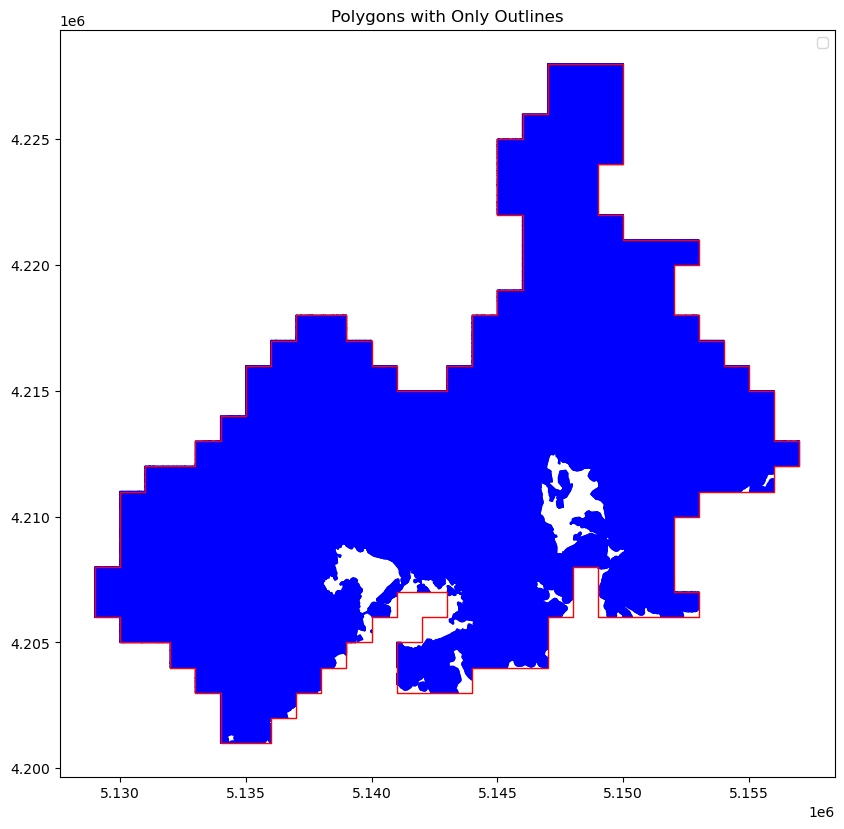

In [62]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
ua.plot(ax=ax, edgecolor='blue', facecolor='blue', label='Layer 1')  # Outline only
urban_center.plot(ax=ax, edgecolor='red', facecolor='none', label='Layer 2')   # Outline only

# Add a legend and title
plt.legend()
plt.title("Polygons with Only Outlines")

# Show the plot
plt.show()

In [64]:
ua.geometry.area.sum()/10000

63333.484489825794

In [65]:
ua

,code_2018,Pop2018,geometry,UA_area_m2
0,11100,471,"POLYGON ((5143107.275 4203136.613, 5143101.192...",19732.67
1,14200,108,"POLYGON ((5142972.463 4204282.270, 5142965.983...",307856.13
2,11210,391,"POLYGON ((5143121.310 4204706.203, 5143113.372...",34073.83
3,14200,0,"POLYGON ((5143869.700 4204627.062, 5143828.543...",9959.94
4,14200,0,"POLYGON ((5143775.042 4204796.414, 5143760.676...",16582.83
...,...,...,...,...
19731,11210,266,"POLYGON ((5135002.341 4215278.282, 5135037.561...",6273.52
19732,12210,0,"POLYGON ((5135039.177 4215751.548, 5135051.811...",17002.19
19733,31000,0,"POLYGON ((5135005.031 4215600.841, 5135023.435...",5074.76
19734,21000,0,"POLYGON ((5135039.177 4215751.548, 5135000.000...",2394.72


In [ ]:
ua_urbc2 = gpd.overlay(ua, urban_center, how='intersection')

In [54]:
ua_urbc.geometry.area.sum()

633334844.8982699

<AxesSubplot: >

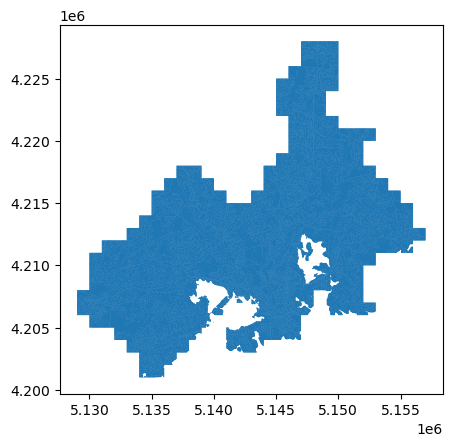

In [53]:
ua_urbc.plot()

Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_39508\3003456345.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


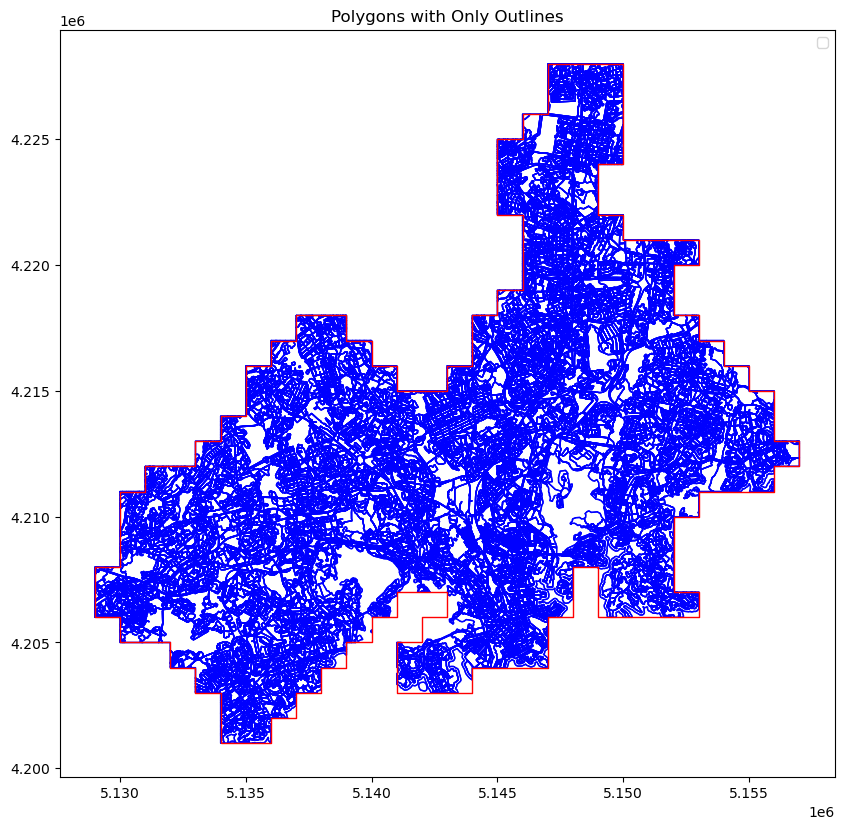

In [61]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
ua_urbc2.plot(ax=ax, edgecolor='blue', facecolor='none', label='Layer 1')  # Outline only
urban_center.plot(ax=ax, edgecolor='red', facecolor='none', label='Layer 2')   # Outline only

# Add a legend and title
plt.legend()
plt.title("Polygons with Only Outlines")

# Show the plot
plt.show()

In [56]:
ua_urbc2 = gpd.clip(ua_urbc, urban_center)

In [60]:
ua_urbc2.geometry.area.sum()/10000

63333.48448982622

<AxesSubplot: >

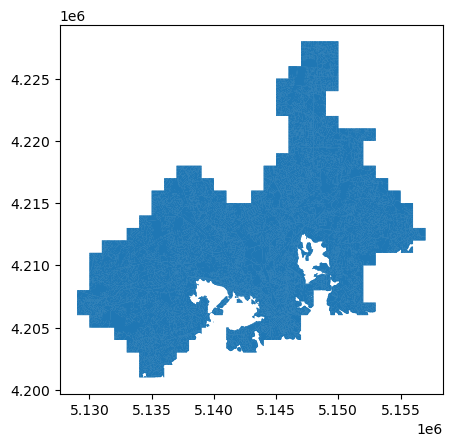

In [57]:
ua_urbc2.plot()

In [52]:
write_log(csv_path, log_entry)

In [35]:
GQA.GQA_FID.max()

GQA_FID    29
GQA_FID    29
dtype: int64

In [ ]:
SA_GQA_total.loc[SA_GQA_total['FID_1'] == 29, 'GQA_FID'] = 29
SA_GQA_total.loc[SA_GQA_total['FID_1'] == 29, 'GQA_m2'] = 157.28734437231236

In [46]:
SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')

In [47]:
SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection') 

In [48]:
SA_GQA_ua = SA_GQA_ua[['GQA_FID', 'GQA_m2','code_2018', 'Pop2018','UA_area_m2', 'geometry']]
SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['UA_area_m2'] # capture proportion from original geometry
SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)
# compute the weighted median for the GQ area
column_to_compute_median = 'GQA_m2'
weighted_median_m2 = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])
weighted_median_Ha = round(weighted_median_m2/10000,2)

In [49]:
weighted_median_Ha

26.54

<AxesSubplot: >

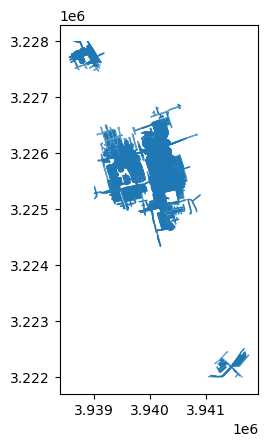

In [44]:
SA_GQA_ua.plot()

In [43]:
SA_GQA_ua

,GQA_FID,GQA_m2,code_2018,Pop2018,UA_area_m2,geometry,final_area_m2,area_prop,Pop2018_poly,Pop2018_final
0,0.0,264511.877586,23000,3,12055.35,"POLYGON ((3939152.287 3225858.752, 3939067.287...",1297.76,0.107650,0.322950,0.0
1,3.0,263556.039692,23000,3,12055.35,"POLYGON ((3939152.287 3225843.752, 3939153.537...",626.51,0.051969,0.155908,0.0
2,7.0,211302.521063,23000,3,12055.35,"POLYGON ((3939157.287 3225828.752, 3939153.120...",489.85,0.040633,0.121900,0.0
3,8.0,126578.763664,23000,3,12055.35,"POLYGON ((3939157.287 3225838.752, 3939152.287...",238.36,0.019772,0.059316,0.0
4,0.0,264511.877586,12100,8,19932.43,"POLYGON ((3939067.287 3225868.752, 3939057.287...",1385.52,0.069511,0.556087,1.0
...,...,...,...,...,...,...,...,...,...,...
1233,NaN,NaN,50000,0,8612.80,"POLYGON ((3941152.287 3222253.752, 3941222.287...",1873.51,0.217526,0.000000,0.0
1234,NaN,NaN,11210,148,23714.71,"MULTIPOLYGON (((3941252.287 3222283.752, 39412...",5855.06,0.246896,36.540564,37.0
1235,NaN,NaN,12100,16,5470.67,"POLYGON ((3941636.039 3222000.000, 3941617.287...",2965.53,0.542078,8.673248,9.0
1236,NaN,NaN,11230,35,5576.56,"POLYGON ((3941662.851 3222000.000, 3941655.039...",21.67,0.003886,0.136007,0.0


In [38]:
SA_GQA_total

,FID_1,FacilityID,Name,FromBreak,ToBreak,Shape_Leng,Shape_Area,geometry,GQA_FID,GQA_m2,GQA_FID\t
0,0,7,Location 7 : 0 - 400,0.0,400.0,4291.586109,137725.0,"POLYGON ((3939402.287 3226368.752, 3939405.923...",0.0,264511.877586,NaN
1,1,10,Location 10 : 0 - 400,0.0,400.0,6503.197989,218637.5,"POLYGON ((3939442.287 3225603.752, 3939421.870...",1.0,391339.171264,NaN
2,2,32,Location 32 : 0 - 400,0.0,400.0,5556.720822,190187.5,"POLYGON ((3939505.620 3226175.418, 3939522.287...",2.0,247356.878735,NaN
3,3,39,Location 39 : 0 - 400,0.0,400.0,4675.505455,87625.0,"POLYGON ((3939266.892 3225516.383, 3939267.287...",3.0,263556.039692,NaN
4,4,53,Location 53 : 0 - 400,0.0,400.0,4412.929354,145137.5,"POLYGON ((3940221.404 3225969.340, 3940281.012...",4.0,216491.174753,NaN
5,5,57,Location 57 : 0 - 400,0.0,400.0,4243.953243,145137.5,"POLYGON ((3940057.287 3226218.752, 3940047.287...",5.0,145137.500000,NaN
6,6,61,Location 61 : 0 - 400,0.0,400.0,3299.987825,70675.0,"POLYGON ((3939647.287 3225523.752, 3939652.287...",6.0,349862.243480,NaN
7,7,83,Location 83 : 0 - 400,0.0,400.0,4715.761814,139925.0,"POLYGON ((3939502.287 3226198.752, 3939502.287...",7.0,211302.521063,NaN
8,8,86,Location 86 : 0 - 400,0.0,400.0,3746.557326,99162.5,"POLYGON ((3939376.215 3226022.770, 3939392.287...",8.0,126578.763664,NaN
9,9,95,Location 95 : 0 - 400,0.0,400.0,5187.709373,195125.0,"POLYGON ((3940346.572 3226108.038, 3940352.287...",9.0,276487.088874,NaN


In [30]:
SA_ua.head()

,HDENS_NAME,CNTR_CODE,code_2018,Pop2018,geometry
0,Pijnacker / Berkel en Rodenrijs,NL,13400,0,"POLYGON ((3939000.000 3225296.323, 3939011.318..."
1,Pijnacker / Berkel en Rodenrijs,NL,23000,3,"POLYGON ((3939152.287 3225843.752, 3939153.537..."
2,Pijnacker / Berkel en Rodenrijs,NL,12100,8,"POLYGON ((3939067.287 3225868.752, 3939057.287..."
3,Pijnacker / Berkel en Rodenrijs,NL,11210,23,"POLYGON ((3939309.686 3225600.010, 3939300.806..."
4,Pijnacker / Berkel en Rodenrijs,NL,11220,22,"POLYGON ((3939232.287 3225528.752, 3939219.787..."


In [25]:
SA_GQA_urbc2 = gpd.clip(SA_GQA_urbc, urban_center)

In [27]:
SA_GQA_urbc2.head()

,FID_1,FacilityID,Name,FromBreak,ToBreak,Shape_Leng,Shape_Area,GQA_FID,GQA_m2,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AR_1,SHAPE_LEN,Batch,Area_ha,geometry
27,28,289,Location 289 : 0 - 400,0.0,400.0,2590.563838,30612.5,28.0,115976.381866,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,None,2100.0,"POLYGON ((3941522.287 3222138.752, 3941521.652..."
28,29,296,Location 296 : 0 - 400,0.0,400.0,4806.446170,113400.0,NaN,NaN,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,None,2100.0,"POLYGON ((3941622.287 3222413.752, 3941647.287..."
12,12,115,Location 115 : 0 - 400,0.0,400.0,3227.610373,38887.5,12.0,115584.416588,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,None,2100.0,"POLYGON ((3940404.972 3224909.215, 3940382.287..."
14,14,129,Location 129 : 0 - 400,0.0,400.0,3188.848240,56812.5,14.0,180402.092933,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,None,2100.0,"POLYGON ((3940102.287 3225218.752, 3940112.287..."
15,15,142,Location 142 : 0 - 400,0.0,400.0,4968.083120,172100.0,15.0,372699.793587,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,None,2100.0,"POLYGON ((3940522.901 3225178.840, 3940527.287..."


In [28]:
SA_GQA_ua2 = gpd.overlay(SA_GQA_urbc2,ua,how='intersection')  

In [29]:
SA_GQA_ua2

,FID_1,FacilityID,Name,FromBreak,ToBreak,Shape_Leng,Shape_Area,GQA_FID,GQA_m2,HDENS_CLST,...,CNTR_CODE,MBRS_CODE_,SHAPE_AR_1,SHAPE_LEN,Batch,Area_ha,code_2018,Pop2018,UA_area_m2,geometry
0,28,289,Location 289 : 0 - 400,0.0,400.0,2590.563838,30612.5,28.0,115976.381866,GEOSTAT21_222,...,NL,1,21000000.0,26000.0,None,2100.0,12220,0,1182848.66,"POLYGON ((3941346.109 3222289.041, 3941347.841..."
1,29,296,Location 296 : 0 - 400,0.0,400.0,4806.446170,113400.0,NaN,NaN,GEOSTAT21_222,...,NL,1,21000000.0,26000.0,None,2100.0,12220,0,1182848.66,"MULTIPOLYGON (((3941765.877 3222406.572, 39416..."
2,28,289,Location 289 : 0 - 400,0.0,400.0,2590.563838,30612.5,28.0,115976.381866,GEOSTAT21_222,...,NL,1,21000000.0,26000.0,None,2100.0,12230,0,84676.66,"POLYGON ((3941557.287 3222103.752, 3941552.287..."
3,29,296,Location 296 : 0 - 400,0.0,400.0,4806.446170,113400.0,NaN,NaN,GEOSTAT21_222,...,NL,1,21000000.0,26000.0,None,2100.0,12230,0,84676.66,"MULTIPOLYGON (((3941772.287 3222393.752, 39417..."
4,28,289,Location 289 : 0 - 400,0.0,400.0,2590.563838,30612.5,28.0,115976.381866,GEOSTAT21_222,...,NL,1,21000000.0,26000.0,None,2100.0,23000,8,29554.03,"MULTIPOLYGON (((3941457.287 3222163.752, 39413..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,24,266,Location 266 : 0 - 400,0.0,400.0,4725.262373,144112.5,24.0,157142.776861,GEOSTAT21_222,...,NL,1,21000000.0,26000.0,None,2100.0,50000,0,8485.52,"MULTIPOLYGON (((3938889.979 3227969.521, 39388..."
1234,23,260,Location 260 : 0 - 400,0.0,400.0,3455.769759,89925.0,23.0,131202.801856,GEOSTAT21_222,...,NL,1,21000000.0,26000.0,None,2100.0,50000,0,8485.52,"MULTIPOLYGON (((3938888.262 3227970.460, 39389..."
1235,25,279,Location 279 : 0 - 400,0.0,400.0,3933.628384,122287.5,25.0,140730.157725,GEOSTAT21_222,...,NL,1,21000000.0,26000.0,None,2100.0,50000,0,8485.52,"MULTIPOLYGON (((3938893.333 3227965.496, 39388..."
1236,27,283,Location 283 : 0 - 400,0.0,400.0,4053.166101,102125.0,27.0,52453.347218,GEOSTAT21_222,...,NL,1,21000000.0,26000.0,None,2100.0,50000,0,8485.52,"MULTIPOLYGON (((3938892.287 3227963.752, 39388..."


In [ ]:
SA_GQA_ua2
SA_GQA_ua = SA_GQA_ua[['GQA_FID', 'GQA_m2','code_2018', 'Pop2018','UA_area_m2', 'geometry']]
SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['UA_area_m2'] # capture proportion from original geometry
SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)
# compute the weighted median for the GQ area
column_to_compute_median = 'GQA_m2'
weighted_median_m2 = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])
weighted_median_Ha = round(weighted_median_m2/10000,2)

In [24]:
GQA.head()

,GQA_FID,GQA_FID,country,fua_name,fua_code,HDENS_2011,code_2018,class_2018,noisy,area_m2,area_ha,area_km2,GQA_m2,geometry
0,0,0,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,13808.748613,1.38,0.01,13808.748613,"POLYGON ((3939295.845 3226123.002, 3939296.034..."
1,1,1,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,14636.604624,1.71,0.02,14636.604624,"POLYGON ((3939471.161 3225355.472, 3939466.413..."
2,2,2,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,2475.051524,1.71,0.02,2475.051524,"POLYGON ((3939737.032 3225958.008, 3939736.829..."
3,3,3,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,5942.944856,0.59,0.01,5942.944856,"POLYGON ((3939272.854 3225486.249, 3939288.183..."
4,4,4,NL,s' Gravenhage,NL001L3,GEOSTAT11_222,14100,Green urban areas,0.0,3133.432255,0.31,0.00,3133.432255,"POLYGON ((3940095.279 3225797.089, 3940103.536..."


In [22]:
SA_GQA_ua

,GQA_FID,GQA_m2,code_2018,Pop2018,UA_area_m2,geometry,final_area_m2,area_prop,Pop2018_poly,Pop2018_final
0,0.0,264511.877586,23000,3,12055.35,"POLYGON ((3939152.287 3225858.752, 3939067.287...",1297.76,0.107650,0.322950,0.0
1,3.0,263556.039692,23000,3,12055.35,"POLYGON ((3939152.287 3225843.752, 3939153.537...",626.51,0.051969,0.155908,0.0
2,7.0,211302.521063,23000,3,12055.35,"POLYGON ((3939157.287 3225828.752, 3939153.120...",489.85,0.040633,0.121900,0.0
3,8.0,126578.763664,23000,3,12055.35,"POLYGON ((3939157.287 3225838.752, 3939152.287...",238.36,0.019772,0.059316,0.0
4,0.0,264511.877586,12100,8,19932.43,"POLYGON ((3939067.287 3225868.752, 3939057.287...",1385.52,0.069511,0.556087,1.0
...,...,...,...,...,...,...,...,...,...,...
1233,NaN,NaN,50000,0,8612.80,"POLYGON ((3941152.287 3222253.752, 3941222.287...",1873.51,0.217526,0.000000,0.0
1234,NaN,NaN,11210,148,23714.71,"MULTIPOLYGON (((3941252.287 3222283.752, 39412...",5855.06,0.246896,36.540564,37.0
1235,NaN,NaN,12100,16,5470.67,"POLYGON ((3941636.039 3222000.000, 3941617.287...",2965.53,0.542078,8.673248,9.0
1236,NaN,NaN,11230,35,5576.56,"POLYGON ((3941662.851 3222000.000, 3941655.039...",21.67,0.003886,0.136007,0.0


In [21]:
write_log(csv_path, log_entry)

In [18]:
ua_urbc_agl_green.geometry.area.sum()

627869.9136967539

In [13]:
ua_urbc.Pop2018.sum()

69673

<AxesSubplot: >

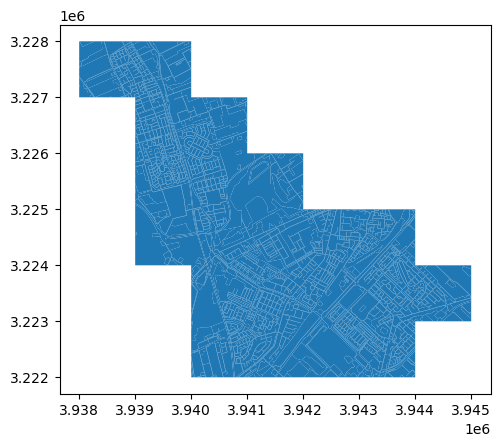

In [12]:
ua_urbc.plot()

In [15]:
ua_urbc_agl.Pop2018.sum()

23856

In [16]:
ua_urbc_agl.head()

,code_2018,Pop2018,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,Area_ha,agglomerationId_identifier,agglomerationName_nameEng,geometry
0,11300,3,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,NaN,2100.0,AG_NL_00_09,Agglomeration Den Haag-Leiden,"POLYGON ((3939026.469 3224561.776, 3939026.073..."
1,23000,66,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,NaN,2100.0,AG_NL_00_09,Agglomeration Den Haag-Leiden,"POLYGON ((3939302.184 3224544.223, 3939307.939..."
2,13400,0,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,NaN,2100.0,AG_NL_00_09,Agglomeration Den Haag-Leiden,"POLYGON ((3939000.000 3225293.377, 3939000.000..."
3,23000,3,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,NaN,2100.0,AG_NL_00_09,Agglomeration Den Haag-Leiden,"POLYGON ((3939027.690 3225845.239, 3939029.384..."
4,12100,8,GEOSTAT21_222,Pijnacker / Berkel en Rodenrijs,GEOSTAT11_222,72259.0,NL,1,21000000.0,26000.0,NaN,2100.0,AG_NL_00_09,Agglomeration Den Haag-Leiden,"POLYGON ((3939038.766 3225925.241, 3939050.140..."


<AxesSubplot: >

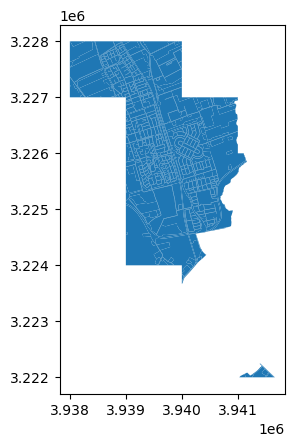

In [14]:
ua_urbc_agl.plot()

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot: >

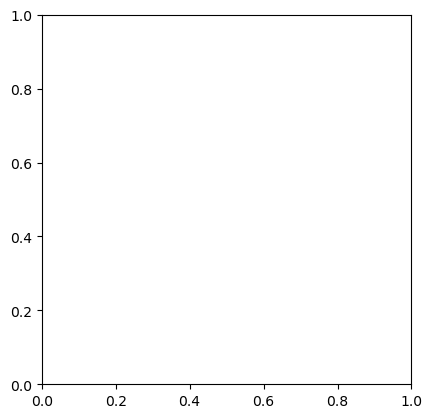

In [19]:
GQA.plot()

In [7]:
# Script adapted to the last computation of urban centers with multiple urban atlas



#SA_ls = sorted(glob.glob(os.path.join(step3_f, '*.shp')))
#SA_ls.reverse()

# Print the list of shapefiles
for sa_name in SA_ls[:1]:
    #uc_code = os.path.basename(sa_name)[:-8]
    uc_code = sa_name
    uc_name = codes.query(f'HDENS_CLST=="{uc_code}"').HDENS_NAME.values[0].strip().replace(" ", "").replace("/", "-")
    timenow = time.strftime("%H:%M:%S", time.localtime())
    print(f'{uc_name} {uc_code} - {timenow}')
    

    # Load urban center
    urban_center = urban_centers.query(f'HDENS_CLST=="{uc_code}"')
    ctry_code = urban_centers.query(f'HDENS_CLST=="{uc_code}"').CNTR_CODE.values[0]
    TotalUCArea = urban_center.geometry.area.sum()
    TotalUCAreaHa = round(TotalUCArea/10000,2)  

    # Erase those areas of SA overlapping the GUAs
    # Load QGA
    GQA_path = os.path.join(path2FinalGQA, f'{uc_code}_finalGQA.shp')
    GQA = gpd.read_file(GQA_path)
    GQA = GQA.reset_index().rename(columns={'index': 'GQA_FID'})
    if not 'GQA_m2' in GQA.columns:
        if 'area' in GQA.columns:
            GQA['GQA_m2'] = GQA['area']
        elif 'Area' in GQA.columns:
            GQA['GQA_m2'] = GQA['Area']
        else:
            
            GQA['GQA_m2'] = GQA.geometry.area
        GQA.to_file(GQA_path, driver='ESRI Shapefile')

    # Remove the outer areas from urban centers      
    file_path = os.path.join(outdata_f,'SA_GQA_urbc', f'{uc_code}_SA_GQA_urbc.shp')
    if not os.path.exists(file_path):
        # Remove GQA delineation from the SA
        file_path_SAd = os.path.join(step3_f, f'{uc_code}_SAd.shp')
        SA_GQA_total = gpd.read_file(file_path_SAd)
        #SA_GQA_total = SA_GQA_total.merge(GQA[['GQA_FID', 'GQA_m2']], left_on='FID_', right_on='GQA_FID', how='left')
        SA_GQA_total = SA_GQA_total.merge(GQA[['GQA_FID', 'GQA_m2']], left_on='FID_1', right_on='GQA_FID', how='left')
        SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
        SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')     
    else:
        SA_GQA_urbc = gpd.read_file(file_path)

    #### Final computations including population
    ## Compute Total Green Areas
    # Read Urban Atlas data
    ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
    file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
    # Read the GeoPackage file
    ua = gpd.read_file(file_path, layer= ua_path[:-5], 
                columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
                use_arrow=True, bbox= tuple(urban_center.total_bounds))
    
    ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
    #ua_urbc = gpd.clip(ua, urban_center)
    UC_UA_Area = ua_urbc.geometry.area.sum()
    UC_UA_AreaHa = round(UC_UA_Area/10000,2)
    UC_UA_Pop = int(ua_urbc.Pop2018.sum())
    
    # area of analysis
    ua_urbc_agl = gpd.overlay(ua_urbc, agls, how='intersection')
    UC_UA_NCM_AreaHa = round(ua_urbc_agl.geometry.area.sum()/10000,2)
    UC_UA_NCM_Pop = int(ua_urbc_agl.Pop2018.sum())

    # Perc coverage area
    # UC_NCM_UA_Area/Ref Area*100
    Perc_coverage_Area = round((UC_UA_NCM_AreaHa/TotalUCAreaHa)*100,2)
    
    # Perc coverage popultation
    # UC_NCM_UA_Pop/UC_UA_Pop*100
    if UC_UA_Pop>0 and UC_UA_NCM_Pop>0:
        Perc_coverage_Pop = round((UC_UA_NCM_Pop/UC_UA_Pop)*100,2)
    else:
        Perc_coverage_Pop = 0

    # All green areas (GUAs and forests) in the urban center (including data outside the ncm)
    TotalGreenArea = ua_urbc.query('code_2018 == "14100" or code_2018 == "31000"').geometry.area.sum()
    TotalGreenAreaHa = round(TotalGreenArea/10000,2)

    # green in the study area
    ua_urbc_agl_green = ua_urbc_agl.query('code_2018 == "14100" or code_2018 == "31000"')
    TotalGreen_urbc_ncm_Ha = round(ua_urbc_agl_green.geometry.area.sum()/10000,2)
    # save to file
    file_path = os.path.join(outdata_f, 'Green_inUCUA_Aglos', f'{uc_code}_greenUCUANCM.shp')
    if not os.path.exists(file_path):
        ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')

    # Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm 
    green_excludedHa = TotalGreenAreaHa - TotalGreen_urbc_ncm_Ha
    
    # Total Green Quiet Areas
    TotalGreenQuietAreaHa = round(GQA.area.sum()/10000,2)

    # Percentage of Green Quiet Areas
    ## Computed as:
    ## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
    ### Quiet_Area/UC_NCM_UA_Green_Area*100
    if TotalGreenQuietAreaHa>0 and TotalGreen_urbc_ncm_Ha>0:
        PercGreenQuietArea = TotalGreenQuietAreaHa/(TotalGreen_urbc_ncm_Ha)*100
    else:
        PercGreenQuietArea = 0

    # Computing Population
    # Total Population with access to GQA
    SA_mask = SA_GQA_urbc[['geometry', 'HDENS_NAME', 'CNTR_CODE', 'HDENS_CLST']].dissolve(by='HDENS_CLST')
    SA_ua = gpd.overlay(SA_mask,ua,how='intersection')  
    TotalGQAPop = SA_ua.Pop2018.sum()

    # Perc Population
    # TotalGQAPop/UC_NCM_UA_Pop*100
    if TotalGQAPop>0 and UC_UA_NCM_Pop>0:
        PercGreenQuietPop = TotalGQAPop/UC_UA_NCM_Pop*100
    else:
        PercGreenQuietPop = 0
    
    # Computing the weighted median
    ua['UA_area_m2'] = round(ua.geometry.area,2)
    SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')  
    if not SA_GQA_ua.empty:  
        SA_GQA_ua = SA_GQA_ua[['GQA_FID', 'GQA_m2','code_2018', 'Pop2018','UA_area_m2', 'geometry']]
        SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
        SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['UA_area_m2'] # capture proportion from original geometry
        SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
        SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)
        # compute the weighted median for the GQ area
        column_to_compute_median = 'GQA_m2'
        weighted_median_m2 = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])
        weighted_median_Ha = round(weighted_median_m2/10000,2)
    else:
        weighted_median_Ha = 0

    # Write values to output table
    log_entry = create_log_entry(uc_code , uc_name , ctry_code , TotalUCAreaHa ,
                            UC_UA_AreaHa , UC_UA_Pop , UC_UA_NCM_AreaHa , UC_UA_NCM_Pop,
                            Perc_coverage_Area , Perc_coverage_Pop , TotalGreen_urbc_ncm_Ha ,
                            TotalGreenQuietAreaHa , TotalGQAPop , PercGreenQuietArea ,
                            PercGreenQuietPop , weighted_median_Ha , TotalGreenAreaHa ,
                            green_excludedHa)
    write_log(csv_path, log_entry)

    


Pijnacker-BerkelenRodenrijs GEOSTAT21_222 - 12:59:42


PermissionError: [Errno 13] Permission denied: 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\OutTables\\GQATotals_DGREGIO_v02.csv'

In [8]:
write_log(csv_path, log_entry)

In [9]:
GQA.head()

,GQA_FID,FID_1,FacilityID,Name,FromBreak,ToBreak,Shape_Leng,Shape_Area,geometry,GQA_m2
0,0,0,7,Location 7 : 0 - 400,0.0,400.0,4291.586109,137725.0,"POLYGON ((3939402.287 3226368.752, 3939405.923...",264511.877586
1,1,1,10,Location 10 : 0 - 400,0.0,400.0,6503.197989,218637.5,"POLYGON ((3939442.287 3225603.752, 3939421.870...",391339.171264
2,2,2,32,Location 32 : 0 - 400,0.0,400.0,5556.720822,190187.5,"POLYGON ((3939505.620 3226175.418, 3939522.287...",247356.878735
3,3,3,39,Location 39 : 0 - 400,0.0,400.0,4675.505455,87625.0,"POLYGON ((3939266.892 3225516.383, 3939267.287...",263556.039692
4,4,4,53,Location 53 : 0 - 400,0.0,400.0,4412.929354,145137.5,"POLYGON ((3940221.404 3225969.340, 3940281.012...",216491.174753


In [10]:
SA_GQA_total

,FID_1,geometry
0,0,"POLYGON ((4224321.026 2709454.176, 4224331.026..."
1,1,"POLYGON ((4224481.026 2709589.176, 4224491.026..."
2,2,"POLYGON ((4223741.026 2709459.176, 4223746.026..."
3,3,"POLYGON ((4224661.026 2709914.176, 4224671.026..."
4,4,"POLYGON ((4222946.026 2708809.176, 4222966.026..."
...,...,...
74,74,"POLYGON ((4224666.026 2712954.176, 4224686.026..."
75,75,"POLYGON ((4226981.026 2713114.176, 4226996.026..."
76,76,"POLYGON ((4227931.026 2713314.176, 4227951.026..."
77,77,"POLYGON ((4222241.026 2708069.176, 4222421.026..."


In [10]:
codes.query(f'HDENS_CLST=="{uc_code}"').HDENS_NAME.values[0].strip().replace(" ", "").replace("/", "-")

'Pijnacker-BerkelenRodenrijs'

In [12]:
ua_urbc_agl_green

NameError: name 'ua_urbc_agl_green' is not defined

In [ ]:
file_path = os.path.join(outdata_f, 'Green_inUCUA_Aglos', f'{uc_code}_greenUCUANCM.shp')
if not os.path.exists(file_path):
    ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')

In [6]:
sa_name

'GEOSTAT21_222'

In [4]:
SA_ls = sorted(glob.glob(os.path.join(step3_f, '*.shp')))

In [27]:
SA_ls[159:160]

['P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\step3_SA\\Dissolved\\GEOSTAT21_441_SAd.shp']

In [33]:
if os.path.exists(csv_path): 
    outtbl = pd.read_csv(csv_path)
    cities_ls = outtbl.uc_code.to_list()
else:
    cities_ls = []

SA_ls = sorted(glob.glob(os.path.join(step3_f, '*.shp')))
#SA_ls.reverse()

# Print the list of shapefiles
for sa_name in SA_ls:
    uc_code = os.path.basename(sa_name)[:-8]
    uc_name = codes.query(f'HDENS_CLST=="{uc_code}"').HDENS_NAME.values[0]
    timenow = time.strftime("%H:%M:%S", time.localtime())
    print(f'{uc_name} {uc_code} - {timenow}')
    
    if uc_code not in cities_ls:

        # Load urban center
        urban_center = urban_centers.query(f'HDENS_CLST=="{uc_code}"')
        ctry_code = urban_centers.query(f'HDENS_CLST=="{uc_code}"').CNTR_CODE.values[0]
        TotalUCArea = urban_center.geometry.area.sum()
        TotalUCAreaHa = round(TotalUCArea/10000,2)  

        # Erase those areas of SA overlapping the GUAs
        # Load QGA
        path = os.path.join(path2FinalGQA, f'{uc_code}_finalGQA.shp')
        GQA = gpd.read_file(path)
        GQA = GQA.reset_index().rename(columns={'index': 'GQA_FID'})
        if 'area' in GQA.columns:
            GQA['GQA_m2'] = GQA['area']
        else:
            GQA['GQA_m2'] = GQA['Area']

        # Remove the outer areas from urban centers      
        file_path = os.path.join(outdata_f,'SA_GQA_urbc', f'{uc_code}_SA_GQA_urbc.shp')
        if not os.path.exists(file_path):
            # Remove GQA delineation from the SA
            file_path_SAd = os.path.join(step3_f, f'{uc_code}_SAd.shp')
            SA_GQA_total = gpd.read_file(file_path_SAd)
            SA_GQA_total = SA_GQA_total.merge(GQA[['GQA_FID', 'GQA_m2']], left_on='FID_', right_on='GQA_FID', how='left')
            SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
            SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')     
        else:
            SA_GQA_urbc = gpd.read_file(file_path)

        #### Final computations including population
        ## Compute Total Green Areas
        # Read Urban Atlas data
        ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
        file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
        # Read the GeoPackage file
        ua = gpd.read_file(file_path, layer= ua_path[:-5], 
                    columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
                    use_arrow=True, bbox= tuple(urban_center.total_bounds))
        
        ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
        #ua_urbc = gpd.clip(ua, urban_center)
        UC_UA_Area = ua_urbc.geometry.area.sum()
        UC_UA_AreaHa = round(UC_UA_Area/10000,2)
        UC_UA_Pop = int(ua_urbc.Pop2018.sum())
        
        # area of analysis
        ua_urbc_agl = gpd.overlay(ua_urbc, agls, how='intersection')
        UC_UA_NCM_AreaHa = round(ua_urbc_agl.geometry.area.sum()/10000,2)
        UC_UA_NCM_Pop = int(ua_urbc_agl.Pop2018.sum())

        # Perc coverage area
        # UC_NCM_UA_Area/Ref Area*100
        Perc_coverage_Area = round((UC_UA_NCM_AreaHa/TotalUCAreaHa)*100,2)
        
        # Perc coverage popultation
        # UC_NCM_UA_Pop/UC_UA_Pop*100
        if UC_UA_Pop>0 and UC_UA_NCM_Pop>0:
            Perc_coverage_Pop = round((UC_UA_NCM_Pop/UC_UA_Pop)*100,2)
        else:
            Perc_coverage_Pop = 0
  
        # All green areas (GUAs and forests) in the urban center (including data outside the ncm)
        TotalGreenArea = ua_urbc.query('code_2018 == "14100" or code_2018 == "31000"').geometry.area.sum()
        TotalGreenAreaHa = round(TotalGreenArea/10000,2)

        # green in the study area
        ua_urbc_agl_green = ua_urbc_agl.query('code_2018 == "14100" or code_2018 == "31000"')
        TotalGreen_urbc_ncm_Ha = round(ua_urbc_agl_green.geometry.area.sum()/10000,2)
        # save to file
        file_path = os.path.join(outdata_f, 'Green_inUCUA_Aglos', f'{uc_code}_greenUCUANCM.shp')
        if not os.path.exists(file_path):
            ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')

        # Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm 
        green_excludedHa = TotalGreenAreaHa - TotalGreen_urbc_ncm_Ha
        
        # Total Green Quiet Areas
        TotalGreenQuietAreaHa = round(GQA.area.sum()/10000,2)

        # Percentage of Green Quiet Areas
        ## Computed as:
        ## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
        ### Quiet_Area/UC_NCM_UA_Green_Area*100
        if TotalGreenQuietAreaHa>0 and TotalGreen_urbc_ncm_Ha>0:
            PercGreenQuietArea = TotalGreenQuietAreaHa/(TotalGreen_urbc_ncm_Ha)*100
        else:
            PercGreenQuietArea = 0

        # Computing Population
        # Total Population with access to GQA
        SA_mask = SA_GQA_urbc[['geometry', 'HDENS_NAME', 'CNTR_CODE', 'HDENS_CLST']].dissolve(by='HDENS_CLST')
        ua['UA_area_m2'] = round(ua.geometry.area,2)
        SA_ua = gpd.overlay(SA_mask,ua,how='intersection')  
        SA_ua['final_area_m2'] = round(SA_ua.geometry.area,2)
        SA_ua['area_prop'] = SA_ua['final_area_m2']/SA_ua['UA_area_m2']
        SA_ua['Pop2018_poly'] = SA_ua['Pop2018']*SA_ua['area_prop']
        TotalGQAPop = round(SA_ua.Pop2018.sum(),0)
        TotalGQAPop_p = round(SA_ua.Pop2018_poly.sum(),0)
        
        # Computing the weighted median        
        SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')  
        if not SA_GQA_ua.empty:  
            SA_GQA_ua = SA_GQA_ua[['GQA_FID', 'GQA_m2','code_2018', 'Pop2018','UA_area_m2', 'geometry']]
            SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
            SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['UA_area_m2'] # capture proportion from original geometry
            SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']

            # compute the weighted median for the GQ area
            column_to_compute_median = 'GQA_m2'
            weighted_median_m2 = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])
            weighted_median_Ha = round(weighted_median_m2/10000,2)
        else:
            weighted_median_Ha = 0

        # Perc Population
        # TotalGQAPop/UC_NCM_UA_Pop*100
        if TotalGQAPop>0 and UC_UA_NCM_Pop>0:
            PercGreenQuietPop = TotalGQAPop/UC_UA_NCM_Pop*100
        else:
            PercGreenQuietPop = 0
        
        if TotalGQAPop_p>0 and UC_UA_NCM_Pop>0:
            PercGreenQuietPop_p = TotalGQAPop_p/UC_UA_NCM_Pop*100
        else:
            PercGreenQuietPop_p = 0

        # Write values to output table
        log_entry = create_log_entry(uc_code , uc_name , ctry_code , TotalUCAreaHa ,
                                UC_UA_AreaHa , UC_UA_Pop , UC_UA_NCM_AreaHa , UC_UA_NCM_Pop,
                                Perc_coverage_Area , Perc_coverage_Pop , TotalGreen_urbc_ncm_Ha ,
                                TotalGreenQuietAreaHa , TotalGQAPop, TotalGQAPop_p, PercGreenQuietArea ,
                                PercGreenQuietPop ,PercGreenQuietPop_p, weighted_median_Ha , TotalGreenAreaHa ,
                                green_excludedHa)
        write_log(csv_path, log_entry)

    


Oulu / Uleåborg GEOSTAT21_002 - 15:28:56
Umeå GEOSTAT21_003 - 15:29:27


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Trondheim GEOSTAT21_004 - 15:30:36
Jyväskylä GEOSTAT21_005 - 15:31:24
Tampere / Tammerfors GEOSTAT21_006 - 15:31:52
Turku / Åbo GEOSTAT21_007 - 15:34:17
Bergen GEOSTAT21_011 - 15:36:11
Tallinn GEOSTAT21_012 - 15:36:50
Uppsala GEOSTAT21_013 - 15:39:06


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Västerås GEOSTAT21_016 - 15:41:26


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Stockholm GEOSTAT21_018 - 15:41:55


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 93 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Tartu GEOSTAT21_021 - 16:02:01
Örebro GEOSTAT21_022 - 16:02:29
Stavanger GEOSTAT21_023 - 16:03:18
Norrköping GEOSTAT21_024 - 16:04:14
Linköping GEOSTAT21_025 - 16:04:46


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Borås GEOSTAT21_026 - 16:06:36
Rīga GEOSTAT21_028 - 16:06:47
Göteborg GEOSTAT21_029 - 16:09:02


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 79 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 335 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 49 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Aalborg GEOSTAT21_031 - 16:18:31
Århus GEOSTAT21_047 - 16:20:13


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 38 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 213 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Helsingborg GEOSTAT21_048 - 16:23:06
Lund GEOSTAT21_049 - 16:23:22
Kaunas GEOSTAT21_051 - 16:24:50
Malmö GEOSTAT21_054 - 16:25:11
Odense GEOSTAT21_060 - 16:26:48
Gdynia GEOSTAT21_065 - 16:28:24
Gdańsk GEOSTAT21_068 - 16:28:48


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 30 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Elbląg GEOSTAT21_070 - 16:29:48
Kiel GEOSTAT21_086 - 16:29:59


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 31 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Olsztyn GEOSTAT21_090 - 16:31:32
Lütten Klein GEOSTAT21_093 - 16:32:00
Rostock GEOSTAT21_094 - 16:32:10
Limerick GEOSTAT21_095 - 16:32:25
Lübeck GEOSTAT21_108 - 16:32:48


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Białystok GEOSTAT21_109 - 16:33:12


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Bremerhaven GEOSTAT21_118 - 16:33:38


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Hamburg GEOSTAT21_119 - 16:34:02
Szczecin GEOSTAT21_120 - 16:49:15


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Harburg GEOSTAT21_121 - 16:49:36
Kasztelanka GEOSTAT21_122 - 16:52:25
Bydgoszcz GEOSTAT21_128 - 16:52:39
Toruń GEOSTAT21_131 - 16:53:01
Cork GEOSTAT21_132 - 16:53:24
Groningen GEOSTAT21_137 - 16:54:23
Gröpelingen / Vegesack GEOSTAT21_140 - 16:55:06
Oldenburg (Oldenburg) GEOSTAT21_141 - 16:57:11


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Bremen GEOSTAT21_145 - 16:57:40
Włocławek GEOSTAT21_150 - 17:01:17
Płock GEOSTAT21_154 - 17:01:24
Gorzów Wielkopolski GEOSTAT21_161 - 17:01:37
Alkmaar GEOSTAT21_168 - 17:01:47
Warszawa GEOSTAT21_171 - 17:02:07


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 41 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Beverwijk/Heemskerk GEOSTAT21_173 - 17:08:26
Zwolle GEOSTAT21_177 - 17:08:49
Poznań GEOSTAT21_178 - 17:09:28
Haarlem GEOSTAT21_181 - 17:11:02
Almere GEOSTAT21_184 - 17:11:42
Berlin GEOSTAT21_186 - 17:12:37


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 71 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 889 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 23 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Potsdam GEOSTAT21_188 - 17:40:24


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Amsterdam GEOSTAT21_190 - 17:45:44
Hilversum GEOSTAT21_196 - 17:48:46
Hengelo GEOSTAT21_199 - 17:49:03
Hannover GEOSTAT21_200 - 17:49:33
Osnabrück GEOSTAT21_201 - 17:53:36
Apeldoorn GEOSTAT21_203 - 17:54:13
Leiden GEOSTAT21_205 - 17:54:52
Alphen aan den Rijn GEOSTAT21_206 - 17:55:13
Enschede GEOSTAT21_208 - 17:55:19
Braunschweig GEOSTAT21_211 - 17:55:53
Zoetermeer GEOSTAT21_216 - 17:56:37
Gouda GEOSTAT21_220 - 17:56:59
Den Haag GEOSTAT21_221 - 17:57:02
Hildesheim GEOSTAT21_223 - 17:59:32


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Nieuwegein / IJsselstein GEOSTAT21_224 - 17:59:45
Magdeburg GEOSTAT21_225 - 18:00:31
Łódź GEOSTAT21_229 - 18:01:24
Zielona Góra GEOSTAT21_233 - 18:02:42
Bielefeld GEOSTAT21_237 - 18:02:58
Arnhem GEOSTAT21_239 - 18:03:18


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Rotterdam GEOSTAT21_240 - 18:04:09
Spijkenisse GEOSTAT21_242 - 18:07:57
Münster GEOSTAT21_243 - 18:08:58
Radom GEOSTAT21_249 - 18:09:30
Lublin GEOSTAT21_255 - 18:09:49
Nijmegen GEOSTAT21_256 - 18:10:37
 s-Hertogenbosch GEOSTAT21_265 - 18:11:13
Breda GEOSTAT21_274 - 18:11:40
Helmond GEOSTAT21_288 - 18:12:15
Göttingen GEOSTAT21_289 - 18:13:08


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Eindhoven GEOSTAT21_292 - 18:13:35
Halle an der Saale GEOSTAT21_295 - 18:15:01
Moers / Rheinhausen GEOSTAT21_297 - 18:15:42
Ruhrgebiet GEOSTAT21_299 - 18:15:45


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 90 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Duisburg GEOSTAT21_302 - 18:59:27
Brugge GEOSTAT21_304 - 19:07:48
Hagen GEOSTAT21_305 - 19:08:15


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 32 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Krefeld GEOSTAT21_307 - 19:16:58
Kielce GEOSTAT21_308 - 19:17:05


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Leipzig GEOSTAT21_312 - 19:17:23
Dunkerque GEOSTAT21_316 - 19:20:27


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Antwerpen GEOSTAT21_317 - 19:20:42
Wrocław GEOSTAT21_318 - 19:21:36
Kassel GEOSTAT21_320 - 19:22:42
Düsseldorf GEOSTAT21_327 - 19:23:05
Remscheid GEOSTAT21_328 - 19:24:37


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 15 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 43 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Mönchengladbach GEOSTAT21_331 - 19:24:42


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Gent GEOSTAT21_332 - 19:25:04
Solingen GEOSTAT21_334 - 19:25:44
Częstochowa GEOSTAT21_335 - 19:26:03
Dresden GEOSTAT21_339 - 19:26:28
Leuven GEOSTAT21_344 - 19:30:20
Köln GEOSTAT21_346 - 19:30:38
Opole GEOSTAT21_348 - 19:33:38
Bruxelles / Brussel GEOSTAT21_349 - 19:33:52
Porz GEOSTAT21_354 - 19:38:56
Liberec GEOSTAT21_358 - 19:39:46
Chemnitz GEOSTAT21_359 - 19:40:04
Aachen GEOSTAT21_360 - 19:40:18
Ústí nad Labem GEOSTAT21_362 - 19:40:45
Bonn GEOSTAT21_363 - 19:40:58
Liège GEOSTAT21_364 - 19:41:26
Rzeszów GEOSTAT21_366 - 19:42:15
Lens GEOSTAT21_367 - 19:42:41


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Górnośląski Związek Metropolitalny GEOSTAT21_376 - 19:43:02


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Tarnów GEOSTAT21_377 - 19:48:32
Charleroi GEOSTAT21_379 - 19:48:45
Arras GEOSTAT21_382 - 19:49:40
Tychy GEOSTAT21_384 - 19:49:53
Kraków GEOSTAT21_385 - 19:50:48


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Koblenz GEOSTAT21_387 - 19:54:35
Bielsko-Biała GEOSTAT21_394 - 19:55:35


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Ostrava GEOSTAT21_397 - 19:55:50
Poruba GEOSTAT21_398 - 19:56:24
Hanau GEOSTAT21_400 - 19:56:47
Frankfurt am Main GEOSTAT21_401 - 19:59:45
Praha GEOSTAT21_402 - 20:05:35
Havířov GEOSTAT21_403 - 20:13:53
Hrabuvka GEOSTAT21_404 - 20:14:22
Wiesbaden GEOSTAT21_405 - 20:14:46
Mainz GEOSTAT21_408 - 20:15:12
Darmstadt GEOSTAT21_413 - 20:15:22
Olomouc GEOSTAT21_414 - 20:15:50
Plzeň GEOSTAT21_416 - 20:16:06
Würzburg GEOSTAT21_417 - 20:16:38


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 15 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 74 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Rouen GEOSTAT21_418 - 20:17:29
Luxembourg GEOSTAT21_419 - 20:19:10
Caen GEOSTAT21_420 - 20:21:02


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Erlangen GEOSTAT21_421 - 20:21:54
Mannheim/Ludwigshafen GEOSTAT21_425 - 20:22:30


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Reims GEOSTAT21_427 - 20:23:18


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Heidelberg GEOSTAT21_428 - 20:24:13
Fürth GEOSTAT21_429 - 20:24:34


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Brno GEOSTAT21_430 - 20:26:01


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 28 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Brest GEOSTAT21_431 - 20:27:13
Mantes en Yvelines GEOSTAT21_432 - 20:28:16
Saarbrücken GEOSTAT21_435 - 20:36:23
Poissy GEOSTAT21_437 - 20:37:36
Les Clayes-sous-Bois GEOSTAT21_440 - 20:45:36
Heilbronn GEOSTAT21_441 - 20:53:04
Maurepas / Montigny-le-Bretonneux GEOSTAT21_443 - 20:53:25
Regensburg GEOSTAT21_445 - 21:02:04


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Karlsruhe GEOSTAT21_447 - 21:02:46
Pforzheim GEOSTAT21_448 - 21:03:57
Stuttgart GEOSTAT21_454 - 21:04:15
Ingolstadt GEOSTAT21_455 - 21:10:47
Vaihingen / Möhringen GEOSTAT21_457 - 21:11:15


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 10 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 56 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Rennes GEOSTAT21_459 - 21:14:18
Reutlingen GEOSTAT21_473 - 21:16:24
Ulm/Neu-Ulm GEOSTAT21_476 - 21:16:44
Linz GEOSTAT21_479 - 21:17:19
Wien GEOSTAT21_481 - 21:19:33
München GEOSTAT21_487 - 21:35:04


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Freiburg im Breisgau GEOSTAT21_488 - 21:46:44
Angers GEOSTAT21_489 - 21:47:54
Salzburg GEOSTAT21_495 - 21:48:46
Nantes GEOSTAT21_496 - 21:49:16


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 50 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 260 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Tours GEOSTAT21_499 - 21:53:31


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Basel GEOSTAT21_510 - 21:55:24
St. Gallen GEOSTAT21_514 - 21:56:20
Besançon GEOSTAT21_519 - 21:56:39
Innsbruck GEOSTAT21_520 - 21:57:19
Zürich GEOSTAT21_521 - 21:57:44
Graz GEOSTAT21_522 - 22:01:12
Biel/Bienne GEOSTAT21_523 - 22:03:05
Bern GEOSTAT21_528 - 22:03:09
Lausanne GEOSTAT21_542 - 22:03:51
Genève GEOSTAT21_549 - 22:04:35
Limoges GEOSTAT21_550 - 22:05:02
Lugano GEOSTAT21_557 - 22:05:57
Clermont-Ferrand GEOSTAT21_558 - 22:06:10
Zagreb GEOSTAT21_561 - 22:08:02


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 25 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Lyon GEOSTAT21_569 - 22:10:52
Saint-Etienne GEOSTAT21_580 - 22:23:12
Rijeka GEOSTAT21_588 - 22:24:39
Bordeaux GEOSTAT21_595 - 22:25:02
Grenoble GEOSTAT21_597 - 22:32:25


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:110: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_ua = gpd.overlay(SA_mask,ua,how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:117: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Gijón GEOSTAT21_620 - 22:34:56
Oviedo GEOSTAT21_624 - 22:35:49
Bilbao GEOSTAT21_650 - 22:36:43


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


San Sebastián/Donostia GEOSTAT21_652 - 22:37:57


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Vigo GEOSTAT21_657 - 22:38:10
León GEOSTAT21_665 - 22:39:14
Split GEOSTAT21_669 - 22:39:36
Nice GEOSTAT21_672 - 22:40:09
Vitoria/Gasteiz GEOSTAT21_674 - 22:42:06
Aix-en-Provence GEOSTAT21_676 - 22:42:50
Martigues / Port-de-Bouc GEOSTAT21_682 - 22:45:06
Pamplona/Iruña GEOSTAT21_687 - 22:45:20
Marseille GEOSTAT21_689 - 22:46:30


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Logroño GEOSTAT21_694 - 22:54:51
Porto GEOSTAT21_706 - 22:55:03
Valladolid GEOSTAT21_712 - 22:58:04
Torrejón de Ardoz GEOSTAT21_768 - 22:58:58
Madrid GEOSTAT21_773 - 23:05:20
Fuenlabrada GEOSTAT21_774 - 23:24:06
Castellón de la Plana/Castelló de la Plana GEOSTAT21_800 - 23:30:25
Valencia GEOSTAT21_809 - 23:30:34
Lefkosia GEOSTAT21_843 - 23:35:15
Lemesos GEOSTAT21_856 - 23:35:49
Valletta GEOSTAT21_867 - 23:36:15


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Helsinki GEOSTAT21_901 - 23:37:34
Oslo GEOSTAT21_902 - 23:41:37
København GEOSTAT21_903 - 23:46:12
Dublin GEOSTAT21_904 - 23:52:59
Utrecht GEOSTAT21_905 - 00:07:49
Paris GEOSTAT21_906 - 00:09:07


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\2347343578.py:57: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Augsburg GEOSTAT21_907 - 02:13:47
Lahti GEOSTAT21_911 - 02:15:10
Jönköping / Huskvarna GEOSTAT21_914 - 02:15:30
Neu Wulmstorf / Neugraben-Fischbek / Hausbruch GEOSTAT21_919 - 02:16:27
Scharwoude / Heerhugowaard GEOSTAT21_922 - 02:19:04
Wuppertal GEOSTAT21_925 - 02:19:26
Saint-Priest / Mions GEOSTAT21_945 - 02:19:31


In [ ]:
write_log(csv_path, log_entry)

In [34]:
tbl = pd.read_csv(csv_path) 
tbl.head()

,uc_code,uc_name,ctry_code,TotalUCAreaHa,UC_UA_AreaHa,UC_UA_Pop,UC_UA_NCM_AreaHa,UC_UA_NCM_Pop,Perc_coverage_Area,Perc_coverage_Pop,TotalGreen_urbc_ncm_Ha,TotalGreenQuietAreaHa,TotalGQAPop,PercGreenQuietArea,PercGreenQuietPop,weighted_median_Ha,TotalGreenAreaHa,green_excludedHa
0,GEOSTAT21_002,Oulu / Uleåborg,FI,2900.0,2900.00,76701,2900.00,76701,100.00,100.00,715.95,340.85,38825.0,47.608073,50.618636,2.37,715.95,0.00
1,GEOSTAT21_003,Umeå,SE,3600.0,3600.00,85430,3600.00,85430,100.00,100.00,949.30,421.74,27183.0,44.426419,31.819033,7.67,949.30,0.00
2,GEOSTAT21_004,Trondheim,NO,7000.0,6792.94,177126,6669.17,177123,95.27,100.00,1289.85,954.85,79888.0,74.027988,45.103120,6.68,1307.75,17.90
3,GEOSTAT21_005,Jyväskylä,FI,2700.0,2700.00,64379,2700.00,64379,100.00,100.00,603.42,369.46,29175.0,61.227669,45.317573,5.46,603.42,0.00
4,GEOSTAT21_006,Tampere / Tammerfors,FI,8200.0,8200.00,196152,8159.01,195838,99.50,99.84,1796.15,1016.24,89868.0,56.578794,45.888949,3.37,1801.40,5.25


In [35]:
tbl.to_csv(csv_path, index=False, encoding="utf-8")

In [31]:
log_entry

['GEOSTAT21_441',
 'Heilbronn',
 'DE',
 2400.0,
 2400.0,
 100177,
 2122.63,
 93871,
 88.44,
 93.71,
 114.79,
 88.28,
 22269.0,
 76.90565380259604,
 23.722981538494317,
 4.14,
 122.19,
 7.3999999999999915]

In [8]:
SA_GQA_ua

,GQA_FID,GQA_m2,code_2018,Pop2018,UA_area_m2,geometry,final_area_m2,area_prop,Pop2018_poly,Pop2018_final
0,0,91687.918884,12220,0,3.443834e+08,"POLYGON ((3737532.895 2880000.000, 3737543.421...",11847.85,0.000034,0.000000,0.0
1,1,1208.064559,12220,0,3.443834e+08,"POLYGON ((3737342.851 2880250.228, 3737332.879...",7242.83,0.000021,0.000000,0.0
2,2,129614.521449,12220,0,3.443834e+08,"MULTIPOLYGON (((3737949.361 2880767.997, 37379...",21985.74,0.000064,0.000000,0.0
3,3,10782.694370,12220,0,3.443834e+08,"POLYGON ((3737683.579 2880757.022, 3737681.225...",37175.81,0.000108,0.000000,0.0
4,4,4240.194748,12220,0,3.443834e+08,"MULTIPOLYGON (((3737402.585 2880764.695, 37373...",26280.71,0.000076,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
1874,89,28513.164237,11210,54,7.287360e+03,"POLYGON ((3731000.000 2885630.552, 3731001.351...",7231.95,0.992396,53.589407,54.0
1875,89,28513.164237,11210,64,6.734230e+03,"POLYGON ((3731126.802 2885621.155, 3731121.609...",6734.23,1.000000,64.000000,64.0
1876,89,28513.164237,11210,51,8.317960e+03,"POLYGON ((3731181.439 2885511.912, 3731168.165...",8317.96,1.000000,51.000000,51.0
1877,89,28513.164237,11210,80,1.073271e+04,"POLYGON ((3731239.168 2885485.170, 3731222.682...",10732.71,1.000000,80.000000,80.0


In [9]:
SA_GQA_ua.Pop2018_poly.sum()

81714.87435043047

In [10]:
file_path_SA_GQA_ua = os.path.join(outdata_f,'SA_GQA_ua', f'{uc_code}_SA_GQA_ua.shp')
SA_GQA_ua.to_file(file_path_SA_GQA_ua, driver='ESRI Shapefile')   

Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_126376\3988194404.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_ua.to_file(file_path_SA_GQA_ua, driver='ESRI Shapefile')


In [12]:
file_path_SA_GQA_ua = os.path.join(outdata_f,'SA', f'{uc_code}_SA_mask.shp')
SA_mask.to_file(file_path_SA_GQA_ua, driver='ESRI Shapefile')   

In [13]:
SA_ua

,HDENS_NAME,CNTR_CODE,code_2018,Pop2018,geometry
0,Maurepas / Montigny-le-Bretonneux,FR,21000,0,"POLYGON ((3730027.052 2884037.266, 3730026.813..."
1,Maurepas / Montigny-le-Bretonneux,FR,12220,0,"MULTIPOLYGON (((3739213.184 2881792.216, 37392..."
2,Maurepas / Montigny-le-Bretonneux,FR,11210,389,"POLYGON ((3729103.938 2882435.228, 3729076.019..."
3,Maurepas / Montigny-le-Bretonneux,FR,11210,160,"MULTIPOLYGON (((3728958.938 2882510.228, 37289..."
4,Maurepas / Montigny-le-Bretonneux,FR,12100,5,"POLYGON ((3729053.938 2882435.228, 3729063.938..."
...,...,...,...,...,...
872,Maurepas / Montigny-le-Bretonneux,FR,11210,54,"POLYGON ((3731000.000 2885630.552, 3731001.351..."
873,Maurepas / Montigny-le-Bretonneux,FR,11210,64,"POLYGON ((3731126.802 2885621.155, 3731121.609..."
874,Maurepas / Montigny-le-Bretonneux,FR,11210,51,"POLYGON ((3731181.439 2885511.912, 3731168.165..."
875,Maurepas / Montigny-le-Bretonneux,FR,11210,80,"POLYGON ((3731239.168 2885485.170, 3731222.682..."


In [14]:
ua['UA_area_m2'] = round(ua.geometry.area,2)
SA_ua = gpd.overlay(SA_mask,ua,how='intersection')  

In [15]:
SA_ua['final_area_m2'] = round(SA_ua.geometry.area,2)
SA_ua['area_prop'] = SA_ua['final_area_m2']/SA_ua['UA_area_m2'] # capture proportion from original geometry
SA_ua['Pop2018_poly'] = SA_ua['Pop2018']*SA_ua['area_prop']
round(SA_ua.Pop2018_poly.sum(),0)

54028.0

In [16]:
ua.head()

,code_2018,Pop2018,geometry,UA_area_m2
0,21000,0,"MULTIPOLYGON (((3730026.813 2884036.647, 37300...",4.767161e+04
1,21000,1,"MULTIPOLYGON (((3729660.852 2884957.545, 37296...",4.309398e+05
2,12220,0,"MULTIPOLYGON (((3690458.999 2887865.449, 36904...",3.443834e+08
3,11230,30,"MULTIPOLYGON (((3729140.131 2885631.625, 37291...",9.476450e+03
4,14200,4,"MULTIPOLYGON (((3728909.508 2886296.253, 37289...",4.494178e+05
...,...,...,...,...
1818,11210,663,"MULTIPOLYGON (((3736438.255 2886133.961, 37364...",6.625567e+04
1819,14200,38,"MULTIPOLYGON (((3736838.121 2885916.147, 37367...",9.074730e+04
1820,31000,0,"MULTIPOLYGON (((3733571.120 2888005.240, 37335...",4.822790e+06
1821,14200,17,"MULTIPOLYGON (((3740045.891 2886208.415, 37400...",5.639415e+05


In [17]:
SA_uc = gpd.clip(SA_mask,urban_center)  

In [18]:
SA_uc.head()

,geometry,HDENS_NAME,CNTR_CODE
HDENS_CLST,,,
GEOSTAT21_443,"MULTIPOLYGON (((3730778.938 2881010.228, 37307...",Maurepas / Montigny-le-Bretonneux,FR


In [20]:
SA_uc_ua = gpd.overlay(SA_uc,ua,how='intersection') 

In [21]:
SA_uc_ua

,HDENS_NAME,CNTR_CODE,code_2018,Pop2018,UA_area_m2,geometry
0,Maurepas / Montigny-le-Bretonneux,FR,21000,0,4.767161e+04,"POLYGON ((3730027.052 2884037.266, 3730026.813..."
1,Maurepas / Montigny-le-Bretonneux,FR,12220,0,3.443834e+08,"MULTIPOLYGON (((3739213.184 2881792.216, 37392..."
2,Maurepas / Montigny-le-Bretonneux,FR,11210,389,3.769582e+04,"POLYGON ((3729103.938 2882435.228, 3729076.019..."
3,Maurepas / Montigny-le-Bretonneux,FR,11210,160,2.575642e+04,"MULTIPOLYGON (((3728958.938 2882510.228, 37289..."
4,Maurepas / Montigny-le-Bretonneux,FR,12100,5,1.150870e+04,"POLYGON ((3729053.938 2882435.228, 3729063.938..."
...,...,...,...,...,...,...
872,Maurepas / Montigny-le-Bretonneux,FR,11210,54,7.287360e+03,"POLYGON ((3731000.000 2885630.552, 3731001.351..."
873,Maurepas / Montigny-le-Bretonneux,FR,11210,64,6.734230e+03,"POLYGON ((3731126.802 2885621.155, 3731121.609..."
874,Maurepas / Montigny-le-Bretonneux,FR,11210,51,8.317960e+03,"POLYGON ((3731181.439 2885511.912, 3731168.165..."
875,Maurepas / Montigny-le-Bretonneux,FR,11210,80,1.073271e+04,"POLYGON ((3731239.168 2885485.170, 3731222.682..."


In [25]:
SA_uc_ua.Pop2018.sum()

109945

In [22]:
SA_uc_ua['final_area_m2'] = round(SA_uc_ua.geometry.area,2)
SA_uc_ua['area_prop'] = SA_uc_ua['final_area_m2']/SA_uc_ua['UA_area_m2'] # capture proportion from original geometry
SA_uc_ua['Pop2018_poly'] = SA_uc_ua['Pop2018']*SA_uc_ua['area_prop']
round(SA_uc_ua.Pop2018_poly.sum(),0)

54028.0

In [23]:
SA_uc_ua

,HDENS_NAME,CNTR_CODE,code_2018,Pop2018,UA_area_m2,geometry,final_area_m2,area_prop,Pop2018_poly
0,Maurepas / Montigny-le-Bretonneux,FR,21000,0,4.767161e+04,"POLYGON ((3730027.052 2884037.266, 3730026.813...",0.05,0.000001,0.000000
1,Maurepas / Montigny-le-Bretonneux,FR,12220,0,3.443834e+08,"MULTIPOLYGON (((3739213.184 2881792.216, 37392...",1424863.95,0.004137,0.000000
2,Maurepas / Montigny-le-Bretonneux,FR,11210,389,3.769582e+04,"POLYGON ((3729103.938 2882435.228, 3729076.019...",302.51,0.008025,3.121736
3,Maurepas / Montigny-le-Bretonneux,FR,11210,160,2.575642e+04,"MULTIPOLYGON (((3728958.938 2882510.228, 37289...",3652.68,0.141816,22.690607
4,Maurepas / Montigny-le-Bretonneux,FR,12100,5,1.150870e+04,"POLYGON ((3729053.938 2882435.228, 3729063.938...",1408.49,0.122385,0.611924
...,...,...,...,...,...,...,...,...,...
872,Maurepas / Montigny-le-Bretonneux,FR,11210,54,7.287360e+03,"POLYGON ((3731000.000 2885630.552, 3731001.351...",7231.95,0.992396,53.589407
873,Maurepas / Montigny-le-Bretonneux,FR,11210,64,6.734230e+03,"POLYGON ((3731126.802 2885621.155, 3731121.609...",6734.23,1.000000,64.000000
874,Maurepas / Montigny-le-Bretonneux,FR,11210,51,8.317960e+03,"POLYGON ((3731181.439 2885511.912, 3731168.165...",8317.96,1.000000,51.000000
875,Maurepas / Montigny-le-Bretonneux,FR,11210,80,1.073271e+04,"POLYGON ((3731239.168 2885485.170, 3731222.682...",10732.71,1.000000,80.000000
